Henning Hoeber, 2025

I investigate collinearity by:
1. Creating multiple AVO realisations, where intercept and gradient are linearly related.
2. Running AVO fits using the Shuey formulation, and with varying degrees of noise
3. Repeatedly doing 2, and then fitting gradient versus intercept in the crossplot resulting from 2
4. Statistically analyising the crossplot slope ie is the same as the one we set up in 1
5. I also derive and apply a prediction for the crossplot, as a function of the AVO noise and show that this works well

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Inputs

In [2]:
# AVO angles, in degrees from where to where, in what increments
theta_deg = np.arange(0, 36, 1)

# -----------------------------
# Simulation parameters
# -----------------------------
N_crossplotPairs    = 25  # This is the number of R0 values for which we run the simulation
N_crossplotFits     = 1000  # for each R0 how many noisy AVO realisations do we create and fit

# The S/N ratios for which we do the analysis
signoisRatio = np.array([0.001, 1, 2, 4, 1000])  

# -----------------------------
# Linear relation between R0 and G
# -----------------------------
# Assume the R0 and G values are along a trendline
slope_true         = -1   # the true slope between R0 and G
zero_crossing_true = 0.0  # assume the trendline goes through zero 

# Draw R0 values and relate to G; we use the same true R0 and G for all values of S/N
# THis is the range +- from which we draw interept values R0
rangeR0 = 0.1

Theoretical noise-induced slope, m_noise = -4.8297


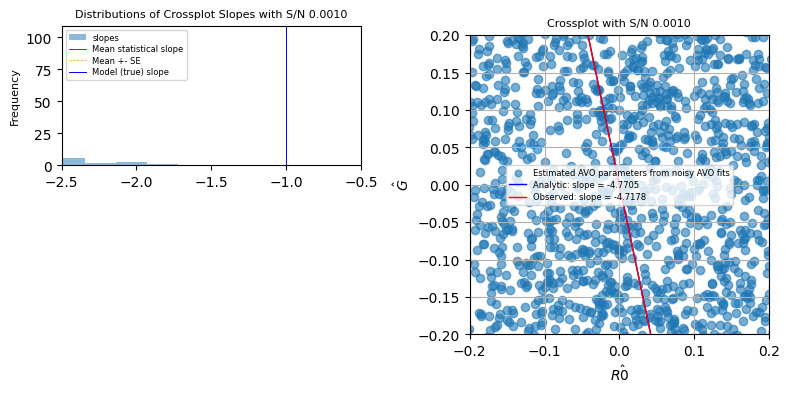

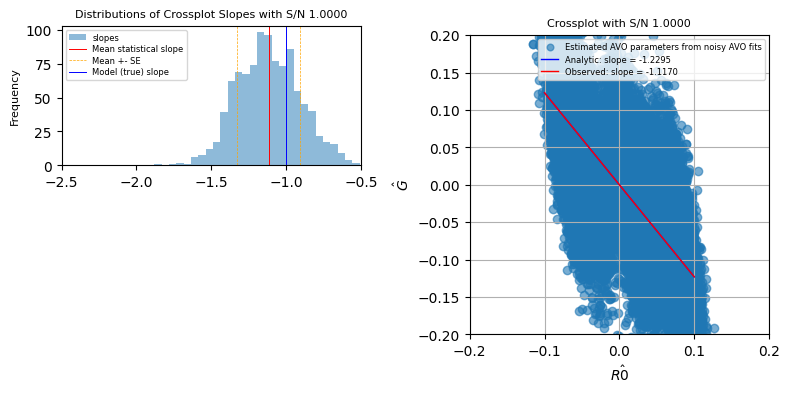

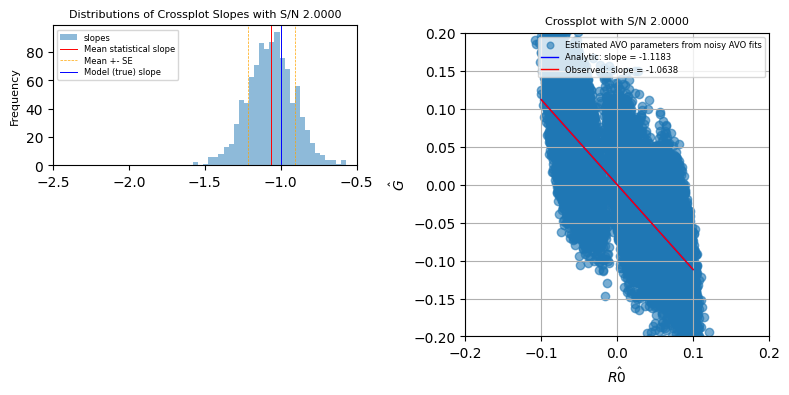

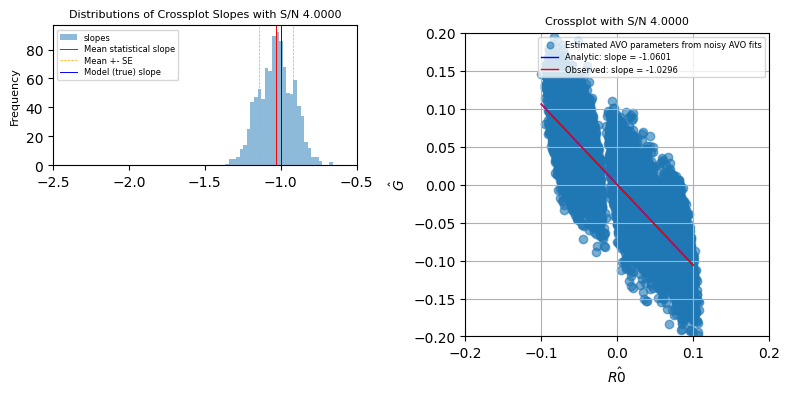

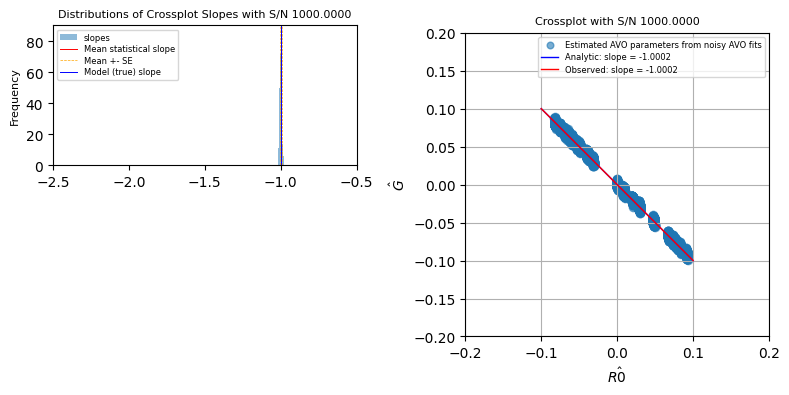

In [3]:
# -----------------------------
# Setup Basis functions and design matrix
# -----------------------------
# Use theta from 0 to 35 degrees (step = 1 degree)
theta_rad = np.radians(theta_deg)
n_AVOpoints = len(theta_rad)

# Basis functions: 1 and sin^2
f1 = np.ones_like(theta_rad)
f2 = np.sin(theta_rad)**2

# Design matrix A (each row: [f1, f2])
A = np.vstack([f1, f2]).T

# Calculate all vector products of basis functions, as these give the variance and covariance
AA = np.sum(f1 * f1)  
# Compute inner products over the data points (assume uniform weights)
B = np.sum(f1 * f2)   # = sum(sin^2(theta))
C = np.sum(f2 * f2)
denom = AA * C - B**2 # Gram matrix inversion brings up the determinant

# in the limit of only noise, the slope in the crossplot converges to this value
slope_purenoise_theory = -B / C
print(f"Theoretical noise-induced slope, m_noise = {slope_purenoise_theory:.4f}")

# At each (R0,G) we have a number of noisy AVO fits to perform (and for each S/N)
slope_noise          = np.zeros(N_crossplotFits)
zero_crossing_noise  = np.zeros(N_crossplotFits)

# For each S/N value, we obtain the average slope and its standard error
slopeMean      = np.zeros_like(signoisRatio)
seSlope        = np.zeros_like(signoisRatio)

# also I calculate an analytic estimate of the slope
slope_analytic = np.zeros_like(signoisRatio)

# Set up the least squares estimates, and signal and noise
R0_noise = np.zeros(N_crossplotPairs)
G_noise  = np.zeros(N_crossplotPairs)

sig            = np.zeros(N_crossplotPairs)
noise_variance = np.zeros(N_crossplotPairs)

# Draw R0 values and relate to G; we use the same true R0 and G for all values of S/N
R0_true = np.random.uniform(-rangeR0, rangeR0, N_crossplotPairs) 
G_true  = np.zeros_like(R0_true)
G_true  = zero_crossing_true + slope_true * R0_true

# The results of all AVO fits
allR0 = np.zeros((len(signoisRatio), N_crossplotFits, N_crossplotPairs))
allG  = np.zeros((len(signoisRatio), N_crossplotFits, N_crossplotPairs))

T_a = np.var(R0_true) # Variance of the true a values

for k in range(len(signoisRatio)):

    # print(k, signoisRatio[k])

    # The result is 1 AVO crossplot slope per AVO fit
    for j in range(N_crossplotFits):  # number of noise realisations per (RO,G); 
                                      # for each of these we run AVO fits at all R(0), 
                                      # then we estimate the R0-G slope; then we average those slopes for the final result
    
        for i in range(N_crossplotPairs):  # number of R0,G pairs for each crossplot

            # The next part to get an average signal to noise
            avo_true = np.array([rangeR0/2, -rangeR0/2])
            dsignal = A @ avo_true            
            sig[i]    = np.mean(dsignal**2)
            noise_variance[i] = sig[i] / signoisRatio[k]            

            # Create the AVO signal part
            avo_true = np.array([R0_true[i], G_true[i]])
            dsignal = A @ avo_true            
 
            # Generate Gaussian noise the length of the AVO and add to AVO signal
            dnoise = np.random.normal(0, np.sqrt(noise_variance[i]), size=n_AVOpoints)
            d = dsignal + dnoise # Simulated data AVO + noise

            # Solve with simple least squares
            beta, _, _, _ = np.linalg.lstsq(A, d, rcond=None)
            R0_noise[i] = beta[0]
            G_noise[i]  = beta[1] 

            allR0[k][j][i] = beta[0]
            allG [k][j][i] = beta[1]
        
        # Compute empirical noise-induced slope from regressing G on R
        # for this one noise realisation, 1 AVO fit per R0 crossplot value
        cov_noise   = np.cov(R0_noise, G_noise)
        slope_noise[j]  = cov_noise[0, 1] / cov_noise[0, 0]
        c_noise     = np.mean(G_noise) - slope_noise[j] * np.mean(R0_noise)
   
    # At each sigma, get the mean of the slopes
    slopeMean[k] = np.mean(slope_noise)
    seSlope[k]   = np.std(slope_noise)

    # Analytic expression for the noise term
    noise_term_a = C / denom  # contribution to Var(delta a)
    noise_term_b = B / denom  # contribution to Cov(delta a, delta b)
    # The expected covariance between estimates:
    cov_ab = slope_true * signoisRatio[k] - noise_term_b
    # The variance of the estimate for a:
    var_a = signoisRatio[k] + noise_term_a
    # The expected observed slope from regressing hat{b} on hat{a}
    slope_analytic[k] = cov_ab / var_a

    # 
    #fig, axes = plt.subplots(1, 2, figsize=(8, 4))  
    fig = plt.figure(figsize=(8, 4))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])  
    ax_left = fig.add_subplot(gs[0, 0])  # First row, first column
    # Histogram of all linear slopes
    ax_left.hist(slope_noise,  bins=30, alpha=0.5, label='slopes')
    ax_left.axvline(slopeMean[k], color='red', label='Mean statistical slope', linewidth=0.7)    
    # Plot mean ± standard error
    ax_left.axvline(slopeMean[k] + seSlope[k], color='orange', linestyle='dashed', linewidth=0.5, label='Mean +- SE')
    ax_left.axvline(slopeMean[k] - seSlope[k], color='orange', linestyle='dashed', linewidth=0.5)

    ax_left.axvline(slope_true, color='blue', label='Model (true) slope', linewidth=0.7)
    ax_left.legend(fontsize=6, labelspacing=0.3, markerscale=0.8)
    ax_left.set_xlim([slope_true-1.5, slope_true+0.5])

    ax_left.set_ylabel("Frequency", fontsize=8)
    ax_left.set_title("Distributions of Crossplot Slopes with S/N {:.4f}".format(signoisRatio[k]), fontsize=8)
     
    # Crossplot
    ax_right = fig.add_subplot(gs[:, 1])  # Full height of the second column
    xmin = -0.2
    xmax = 0.2
    ax_right.set_xlim([xmin, xmax])
    ax_right.set_ylim([xmin, xmax])
    
    ax_right.set_xlabel(r'$\hat{R0}$')
    ax_right.set_ylabel(r'$\hat{G}$')
    ax_right.set_title("Crossplot with S/N {:.4f}".format(signoisRatio[k]), fontsize=8)
    ax_right.scatter(allR0[k][:][:], allG[k][:][:], label="Estimated AVO parameters from noisy AVO fits", alpha=0.6)
    # Plot regression line for signal+noise fits:
    beta1_range = np.linspace(-0.1, 0.1, 100)
    trendline =  slope_analytic[k]  * beta1_range  
    ax_right.plot(beta1_range, trendline, 'b-', linewidth=1, label=f'Analytic: slope = {slope_analytic[k]:.4f}')
    ax_right.plot(beta1_range, trendline, 'r-', linewidth=1, label=f'Observed: slope = {slopeMean[k]:.4f}')
    ax_right.set_aspect('equal')
    ax_right.legend(fontsize=6, labelspacing=0.4, markerscale=0.8)
    ax_right.grid()
    
    # Adjust spacing between subplots for better visualization
    plt.tight_layout()
    
    # Show the plots
    plt.show()
    

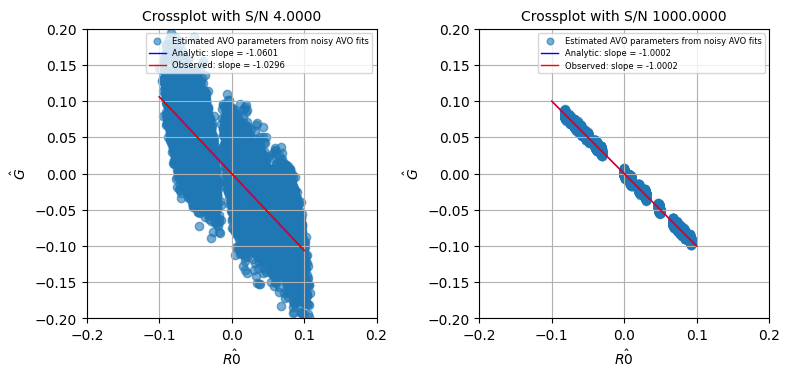

In [4]:
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize for horizontal layout

k=3
xmin = -0.2
xmax = 0.2
axes[0].set_xlim([xmin, xmax])
axes[0].set_ylim([xmin, xmax])
axes[0].set_xlabel(r'$\hat{R0}$')
axes[0].set_ylabel(r'$\hat{G}$')
axes[0].set_title("Crossplot with S/N {:.4f}".format(signoisRatio[k]), fontsize=10)
axes[0].scatter(allR0[k][:][:], allG[k][:][:], label="Estimated AVO parameters from noisy AVO fits", alpha=0.6)
# Plot regression line for signal+noise fits:
beta1_range = np.linspace(-0.1, 0.1, 100)
trendline =  slope_analytic[k]  * beta1_range  
axes[0].plot(beta1_range, trendline, 'b-', linewidth=1, label=f'Analytic: slope = {slope_analytic[k]:.4f}')
axes[0].plot(beta1_range, trendline, 'r-', linewidth=1, label=f'Observed: slope = {slopeMean[k]:.4f}')
axes[0].set_aspect('equal')
axes[0].legend(fontsize=6, labelspacing=0.4, markerscale=0.8)
axes[0].grid()

# Second subplot
k=4
axes[1].set_xlim([xmin, xmax])
axes[1].set_ylim([xmin, xmax])

axes[1].set_xlabel(r'$\hat{R0}$')
axes[1].set_ylabel(r'$\hat{G}$')
axes[1].set_title("Crossplot with S/N {:.4f}".format(signoisRatio[k]), fontsize=10)
axes[1].scatter(allR0[k][:][:], allG[k][:][:], label="Estimated AVO parameters from noisy AVO fits", alpha=0.6)
# Plot regression line for signal+noise fits:
beta1_range = np.linspace(-0.1, 0.1, 100)
trendline =  slope_analytic[k]  * beta1_range  
axes[1].plot(beta1_range, trendline, 'b-', linewidth=1, label=f'Analytic: slope = {slope_analytic[k]:.4f}')
axes[1].plot(beta1_range, trendline, 'r-', linewidth=1, label=f'Observed: slope = {slopeMean[k]:.4f}')
axes[1].set_aspect('equal')
axes[1].legend(fontsize=6, labelspacing=0.4, markerscale=0.8)
axes[1].grid()

# Adjust spacing between subplots for better visualization
plt.tight_layout()

# Show the plots
plt.show()

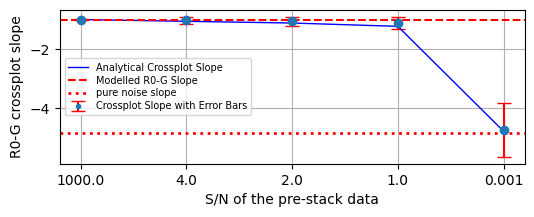

In [5]:
# Replace x values with indices (0, 1, 2, 3, 4)
x_indices = range(len(signoisRatio))

# Create the plot
plt.figure(figsize=(6, 2))
plt.errorbar(x_indices, slopeMean, yerr=seSlope, fmt='o', label='Crossplot Slope with Error Bars', capsize=5, ecolor='red')
plt.plot(x_indices, slope_analytic, 'b-', linewidth=1, label=r'Analytical Crossplot Slope')

# Adjust the x-axis ticks to match the original values
plt.xticks(x_indices, signoisRatio)
# Flip the x-axis
plt.gca().invert_xaxis()

# Add labels and title
plt.axhline(y=slope_true, color='r', linestyle='--', label='Modelled R0-G Slope')
plt.axhline(slope_purenoise_theory, color='red', linestyle=':', linewidth=2, label=r'pure noise slope')

plt.xlabel(r'S/N of the pre-stack data')
plt.ylabel(r'R0-G crossplot slope')
plt.legend(fontsize=7 ,labelspacing=0.3, markerscale=0.5)
plt.grid()

# Show the plot
plt.grid(True)
plt.show()